In [189]:
### Problem 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread,imsave

imFile = 'stpeters_probe_small.png'
compositeFile = 'tennis.png'
targetFile = 'interior.jpg'

# This loads and returns all of the images needed for the problem
# data - the image of the spherical mirror
# tennis - the image of the tennis ball that we will relight
# target - the image that we will paste the tennis ball onto
def loadImages():
    imFile = 'stpeters_probe_small.png'
    compositeFile = 'tennis.png'
    targetFile = 'interior.jpg'
    
    data = imread(imFile).astype('float')*1.5
    tennis = imread(compositeFile).astype('float')
    target = imread(targetFile).astype('float')/255 

    return data, tennis, target
    

# This function takes as input a square image of size m x m x c
# where c is the number of color channels in the image.  We
# assume that the image contains a scphere and that the edges
# of the sphere touch the edge of the image.
# The output is a tuple (ns, vs) where ns is an n x 3 matrix
# where each row is a unit vector of the direction of incoming light
# vs is an n x c vector where the ith row corresponds with the
# image intensity of incoming light from the corresponding row in ns
def extractNormals(img):

    # Assumes the image is square
    d = img.shape[0]
    r = d / 2
    ns = []
    vs = []
    for i in range(d):
        for j in range(d):

            # Determine if the pixel is on the sphere
            x = j - r
            y = i - r
            if x*x + y*y > r*r-100:
                continue

            # Figure out the normal vector at the point
            # We assume that the image is an orthographic projection
            z = np.sqrt(r*r-x*x-y*y)
            n = np.asarray([x,y,z])
            n = n / np.sqrt(np.sum(np.square(n)))
            view = np.asarray([0,0,-1])
            n = 2*n*(np.sum(n*view))-view
            ns.append(n)
            vs.append(img[i,j])

    return np.asarray(ns), np.asarray(vs)

# This function renders a diffuse sphere of radius r
# using the spherical harmonic coefficients given in
# the input coeff where coeff is a 9 x c matrix
# with c being the number of color channels
# The output is an 2r x 2r x c image of a diffuse sphere
# and the value of -1 on the image where there is no sphere
def renderSphere(r,coeff):

    d = 2*r
    img = -np.ones((d,d,3))
    ns = []
    ps = []

    for i in range(d):
        for j in range(d):

            # Determine if the pixel is on the sphere
            x = j - r
            y = i - r
            if x*x + y*y > r*r:
                continue

            # Figure out the normal vector at the point
            # We assume that the image is an orthographic projection
            z = np.sqrt(r*r-x*x-y*y)
            n = np.asarray([x,y,z])
            n = n / np.sqrt(np.sum(np.square(n)))
            ns.append(n)
            ps.append((i,j))

    ns = np.asarray(ns) 
    
    # scale the output
    ns = ns / 384
    
    B = computeBasis(ns)
    vs = B.dot(coeff) 

    for p,v in zip(ps,vs):
        img[p[0],p[1]] = np.clip(v,0,255)

    return img

# relights the sphere in img, which is assumed to be a square image
# coeff is the matrix of spherical harmonic coefficients
def relightSphere(img, coeff):
    img = renderSphere(int(img.shape[0]/2),coeff)/255*img/255 
    return img

# Copies the image of source onto target
# pixels with values of -1 in source will not be copied
def compositeImages(source, target):
    
    # Assumes that all pixels not equal to 0 should be copied
    out = target.copy()
    cx = int(target.shape[1]/2)
    cy = int(target.shape[0]/2)
    sx = cx - int(source.shape[1]/2)
    sy = cy - int(source.shape[0]/2)

    for i in range(source.shape[0]):
        for j in range(source.shape[1]):
            if np.sum(source[i,j]) >= 0:
                out[sy+i,sx+j] = source[i,j]

    return out

# Fill in this function to compute the basis functions
# This function is used in renderSphere()
def computeBasis(ns):
    # Returns the first 9 spherical harmonic basis functions

    #################################################
    # TODO: Compute the first 9 basis functions
    #################################################
    B = np.zeros((len(ns), 9))
    for i in range(len(ns)):
        B[i, 0] = 1
        B[i, 1] = ns[i, 1]
        B[i, 2] = ns[i, 0]
        B[i, 3] = ns[i, 2]
        B[i, 4] = ns[i, 0] * ns[i, 1]
        B[i, 5] = ns[i, 1] * ns[i, 2]
        B[i, 6] = 3 * ns[i, 2] ** 2 - 1
        B[i, 7] = ns[i, 0] * ns[i, 2]
        B[i, 8] = ns[i, 0] ** 2 - ns[i, 1] ** 2
    
    return B

Coefficients:
[[  2.13318421e+02   1.70780299e+02   1.57126297e+02]
 [ -3.23046362e+01  -2.02975310e+01  -1.45516114e+01]
 [ -4.31689131e+00  -3.80778081e+00  -4.83616306e+00]
 [ -4.89811386e+00  -3.37684058e+00  -1.14207091e+00]
 [ -7.05901066e+03  -7.39934207e+03  -4.26448732e+03]
 [ -3.05378224e+02  -1.56329401e+02   3.50285345e+02]
 [ -9.76079364e+00  -5.33182216e+00  -1.55699782e+00]
 [  7.30792588e+02   3.52130316e+02  -6.11683200e+02]
 [ -9.08887079e+00  -3.84309477e+00  -4.16456437e+00]]


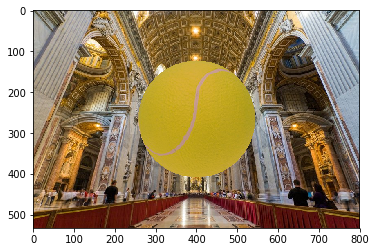

In [190]:
if __name__ == '__main__':

    data,tennis,target = loadImages()
    ns, vs = extractNormals(data)    
    B = computeBasis(ns)

    # reduce the number of samples because computing the SVD on
    # the entire data set takes too long
    Bp = B[::50]
    vsp = vs[::50]
    
    #################################################
    # TODO: Solve for the coefficients using least squares
    # or total least squares here
    ##################################################
    
    # OLS
    #coeff = np.linalg.inv(Bp.T @ Bp) @ Bp.T @ vsp
    
    # TLS
    BV = np.hstack([Bp, vsp])
    VT = np.linalg.svd(BV)[2]
    V = VT.T
    Vxy = V[0:Bp.shape[1],Bp.shape[1]:]     
    Vyy = V[Bp.shape[1]:,Bp.shape[1]:] 
    Vyy_inv = np.linalg.inv(VYY) 
    coeff = -Vxy @ Vyy_inv 
    
    img = relightSphere(tennis,coeff) 

    output = compositeImages(img,target) 

    print('Coefficients:\n'+str(coeff))

    plt.figure(1)
    plt.imshow(output)
    plt.show()

    #imsave('output.png',output)

In [165]:
vsp

array([[ 309. ,  265.5,  234. ],
       [ 184.5,  157.5,  142.5],
       [ 282. ,  243. ,  214.5],
       ..., 
       [ 264. ,  222. ,  199.5],
       [ 244.5,  211.5,  192. ],
       [ 192. ,  160.5,  144. ]])

In [95]:
(Bp.T @ Bp - Sig[-3] ** 2 * np.identity(Bp.shape[1])).shape

ValueError: operands could not be broadcast together with shapes (12,) (9,9) 

In [100]:
Sig

array([[  1.97242074e+04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.13371638e+03,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   3.15377927e+02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.47019961e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
    

In [41]:
vsp[:,[0]]

array([[ 309. ],
       [ 184.5],
       [ 282. ],
       ..., 
       [ 264. ],
       [ 244.5],
       [ 192. ]])

In [61]:
BV1 = np.hstack([Bp, vsp[:,[0]]])

In [62]:
np.linalg.svd(BV1, compute_uv=False)[9]

15.711959106304798

In [68]:
np.diag([2,3,3])

array([[2, 0, 0],
       [0, 3, 0],
       [0, 0, 3]])